In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.utils.rnn as rnn_utils
import time
import pickle
from termcolor import colored

# Raw code
  - paper's code

In [2]:
def genData(file,max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,
             'L':11,'K':12,'M':13,'F':14,'P':15,'O':16,'S':17,'U':18,'T':19,
             'W':20,'Y':21,'V':22,'X':23}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
        
    long_pep_counter=0
    pep_codes=[]
    labels=[]
    for pep in lines:
        pep,label=pep.split(",")
        labels.append(int(label))
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(torch.tensor(current_pep))
        else:
            long_pep_counter += 1
    print("length > {}:".format(max_len),long_pep_counter)
    data = rnn_utils.pad_sequence(pep_codes, batch_first=True)  # padding
    return data,torch.tensor(labels)

In [3]:
class newModel(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(4050,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # euclidean_distance: [128]
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +     # calmp夹断用法
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))     
        
        return loss_contrastive
    
    
def collate(batch):
    seq1_ls=[]
    seq2_ls=[]
    label1_ls=[]
    label2_ls=[]
    label_ls=[]
    batch_size=len(batch)
    for i in range(int(batch_size/2)):
        seq1,label1=batch[i][0],batch[i][1]
        seq2,label2=batch[i+int(batch_size/2)][0],batch[i+int(batch_size/2)][1]
        label1_ls.append(label1.unsqueeze(0))
        label2_ls.append(label2.unsqueeze(0))
        label=(label1^label2)
        seq1_ls.append(seq1.unsqueeze(0))
        seq2_ls.append(seq2.unsqueeze(0))
        label_ls.append(label.unsqueeze(0))
    seq1=torch.cat(seq1_ls).to(device)
    seq2=torch.cat(seq2_ls).to(device)
    label=torch.cat(label_ls).to(device)
    label1=torch.cat(label1_ls).to(device)
    label2=torch.cat(label2_ls).to(device)
    return seq1,seq2,label,label1,label2
    

* model architecture

In [5]:
data,label=genData("compareModel/2021ACS_PepFormer/dataset/Homo_sapiens.csv",81)
print(data.shape,label.shape)

train_data,train_label=data[:70000],label[:70000]
test_data,test_label=data[70000:],label[70000:]

train_dataset = Data.TensorDataset(train_data, train_label)
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_iter_cont = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                                                  shuffle=True, collate_fn=collate)

length > 81: 0
torch.Size([90000, 79]) torch.Size([90000])


In [6]:
device = torch.device("cuda",0)
model = newModel().to(device)

print(model)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('total param cnt : {:,}'.format(params))

newModel(
  (embedding): Embedding(24, 512, padding_idx=0)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=Fals

* model evaluation

In [7]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        acc_sum += (outputs.argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

def to_log(log):
    with open("compareModel/2021ACS_PepFormer/modelLog.log","a+") as f:
        f.write(log+'\n')

In [35]:
for num_model in range(2):
    net=newModel().to(device)
    lr = 0.0001
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=5e-4)
    criterion = ContrastiveLoss()
    criterion_model = nn.CrossEntropyLoss(reduction='sum')
    
    best_acc=0
    EPOCH=5
    for epoch in range(EPOCH):
        loss_ls=[]
        loss1_ls=[]
        loss2_3_ls=[]
        t0=time.time()
        net.train()
        for seq1,seq2,label,label1,label2 in train_iter_cont:
                output1=net(seq1)
                output2=net(seq2)
                output3=net.trainModel(seq1)
                output4=net.trainModel(seq2)
                
                loss1=criterion(output1, output2, label)
                loss2=criterion_model(output3,label1)
                loss3=criterion_model(output4,label2)
                loss=loss1+loss2+loss3
    #             print(loss)
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                loss_ls.append(loss.item())
                loss1_ls.append(loss1.item())
                loss2_3_ls.append((loss2+loss3).item())


        net.eval() 
        with torch.no_grad(): 
            train_acc=evaluate_accuracy(train_iter,net)
            test_acc=evaluate_accuracy(test_iter,net)
            
        results=f"epoch: {epoch+1}, loss: {np.mean(loss_ls):.5f}, loss1: {np.mean(loss1_ls):.5f}, loss2_3: {np.mean(loss2_3_ls):.5f}\n"
        results+=f'\ttrain_acc: {train_acc:.4f}, test_acc: {colored(test_acc,"red")}, time: {time.time()-t0:.2f}'
        print(results)
        to_log(results)
        if test_acc>best_acc:
            best_acc=test_acc
            torch.save({"best_acc":best_acc,"model":net.state_dict()},f'compareModel/2021ACS_PepFormer/Model/{num_model}.pl')
            print(f"best_acc: {best_acc}")

epoch: 1, loss: 181.73344, loss1: 2.59739, loss2_3: 179.13606
	train_acc: 0.5578, test_acc: 0.5561, time: 36.31
best_acc: 0.5561
epoch: 2, loss: 175.95414, loss1: 1.02178, loss2_3: 174.93236
	train_acc: 0.5487, test_acc: 0.54865, time: 36.38
epoch: 3, loss: 174.22681, loss1: 1.02853, loss2_3: 173.19829
	train_acc: 0.5860, test_acc: 0.58595, time: 36.33
best_acc: 0.58595
epoch: 4, loss: 162.11159, loss1: 1.02037, loss2_3: 161.09122
	train_acc: 0.6842, test_acc: 0.68805, time: 36.34
best_acc: 0.68805
epoch: 5, loss: 138.78763, loss1: 0.98040, loss2_3: 137.80723
	train_acc: 0.7542, test_acc: 0.75475, time: 36.39
best_acc: 0.75475
epoch: 1, loss: 181.11985, loss1: 2.38522, loss2_3: 178.73463
	train_acc: 0.5336, test_acc: 0.5331, time: 36.31
best_acc: 0.5331
epoch: 2, loss: 176.11953, loss1: 1.02278, loss2_3: 175.09675
	train_acc: 0.5570, test_acc: 0.5606, time: 36.32
best_acc: 0.5606
epoch: 3, loss: 159.19088, loss1: 1.01531, loss2_3: 158.17557
	train_acc: 0.7211, test_acc: 0.72255, time: 

# New Train

# 1. Make Data X_train, y_train, X_test, y_test

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [9]:
df_detect_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
df_detect_peptide_test = pd.read_csv('data/df_detect_peptide_test.csv')

tra, val = train_test_split(df_detect_peptide_train[['PEP', 'ID']], test_size=0.2, random_state=7)
tra.to_csv('compareModel/2021ACS_PepFormer/detect_peptide_train.csv', header=False, index=False)
val.to_csv('compareModel/2021ACS_PepFormer/detect_peptide_val.csv', header=False, index=False)
df_detect_peptide_test[['PEP', 'ID']].to_csv('compareModel/2021ACS_PepFormer/detect_peptide_test.csv', header=False, index=False)

In [11]:
train_data,train_label=genData("compareModel/2021ACS_PepFormer/detect_peptide_train.csv",30)
print(train_data.shape, train_label.shape)
train_dataset = Data.TensorDataset(train_data, train_label)

val_data,val_label=genData("compareModel/2021ACS_PepFormer/detect_peptide_val.csv",30)
print(val_data.shape, val_label.shape)
val_dataset = Data.TensorDataset(val_data, val_label)

test_data,test_label=genData("compareModel/2021ACS_PepFormer/detect_peptide_test.csv",30)
print(test_data.shape, test_label.shape)
test_dataset = Data.TensorDataset(test_data, test_label)

batch_size=256
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_iter_cont = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                                                  shuffle=True, collate_fn=collate)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

length > 30: 0
torch.Size([215352, 30]) torch.Size([215352])
length > 30: 0
torch.Size([53838, 30]) torch.Size([53838])
length > 30: 0
torch.Size([67298, 30]) torch.Size([67298])


# 2. train

In [25]:
class newModel(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(1600,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # euclidean_distance: [128]
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +     # calmp夹断用法
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))     
        
        return loss_contrastive
    
    
def collate(batch):
    seq1_ls=[]
    seq2_ls=[]
    label1_ls=[]
    label2_ls=[]
    label_ls=[]
    batch_size=len(batch)
    for i in range(int(batch_size/2)):
        seq1,label1=batch[i][0],batch[i][1]
        seq2,label2=batch[i+int(batch_size/2)][0],batch[i+int(batch_size/2)][1]
        label1_ls.append(label1.unsqueeze(0))
        label2_ls.append(label2.unsqueeze(0))
        label=(label1^label2)
        seq1_ls.append(seq1.unsqueeze(0))
        seq2_ls.append(seq2.unsqueeze(0))
        label_ls.append(label.unsqueeze(0))
    seq1=torch.cat(seq1_ls).to(device)
    seq2=torch.cat(seq2_ls).to(device)
    label=torch.cat(label_ls).to(device)
    label1=torch.cat(label1_ls).to(device)
    label2=torch.cat(label2_ls).to(device)
    return seq1,seq2,label,label1,label2
    

In [26]:
for num_model in range(1):  # just one train
    net=newModel().to(device)
    lr = 0.0001
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=5e-4)
    criterion = ContrastiveLoss()
    criterion_model = nn.CrossEntropyLoss(reduction='sum')
    
    best_acc=0
    EPOCH=250
    for epoch in range(EPOCH):
        loss_ls=[]
        loss1_ls=[]
        loss2_3_ls=[]
        t0=time.time()
        net.train()
        for seq1,seq2,label,label1,label2 in train_iter_cont:
                output1=net(seq1)
                output2=net(seq2)
                output3=net.trainModel(seq1)
                output4=net.trainModel(seq2)
                
                loss1=criterion(output1, output2, label)
                loss2=criterion_model(output3,label1)
                loss3=criterion_model(output4,label2)
                loss=loss1+loss2+loss3
    #             print(loss)
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                loss_ls.append(loss.item())
                loss1_ls.append(loss1.item())
                loss2_3_ls.append((loss2+loss3).item())


        net.eval() 
        with torch.no_grad(): 
            train_acc=evaluate_accuracy(train_iter,net)
            test_acc=evaluate_accuracy(val_iter,net)
            
        results=f"epoch: {epoch+1}, loss: {np.mean(loss_ls):.5f}, loss1: {np.mean(loss1_ls):.5f}, loss2_3: {np.mean(loss2_3_ls):.5f}\n"
        results+=f'\ttrain_acc: {train_acc:.4f}, test_acc: {colored(test_acc,"red")}, time: {time.time()-t0:.2f}'
        print(results)
        to_log(results)
        if test_acc>best_acc:
            best_acc=test_acc
            torch.save({"best_acc":best_acc,"model":net.state_dict()},f'compareModel/2021ACS_PepFormer/Model/{num_model}.pl')
            print(f"best_acc: {best_acc}")

epoch: 1, loss: 157.79544, loss1: 1.45590, loss2_3: 156.33954
	train_acc: 0.7599, test_acc: 0.7590549426055946, time: 64.05
best_acc: 0.7590549426055946
epoch: 2, loss: 124.56889, loss1: 0.92612, loss2_3: 123.64277
	train_acc: 0.7897, test_acc: 0.7894795497603923, time: 63.93
best_acc: 0.7894795497603923
epoch: 3, loss: 118.81992, loss1: 0.90422, loss2_3: 117.91570
	train_acc: 0.7891, test_acc: 0.7878450165310747, time: 65.07
epoch: 4, loss: 115.51865, loss1: 0.88433, loss2_3: 114.63432
	train_acc: 0.7891, test_acc: 0.7902225194100821, time: 64.20
best_acc: 0.7902225194100821
epoch: 5, loss: 114.16350, loss1: 0.87263, loss2_3: 113.29087
	train_acc: 0.7854, test_acc: 0.7858018499944277, time: 63.56
epoch: 6, loss: 111.80736, loss1: 0.86087, loss2_3: 110.94649
	train_acc: 0.8099, test_acc: 0.8092611166833835, time: 64.21
best_acc: 0.8092611166833835
epoch: 7, loss: 109.85247, loss1: 0.84179, loss2_3: 109.01068
	train_acc: 0.8106, test_acc: 0.8107099075002786, time: 63.84
best_acc: 0.8107

epoch: 58, loss: 97.93607, loss1: 0.74302, loss2_3: 97.19305
	train_acc: 0.8348, test_acc: 0.8316059288978045, time: 52.46
epoch: 59, loss: 97.90876, loss1: 0.74537, loss2_3: 97.16339
	train_acc: 0.8345, test_acc: 0.8321445818938297, time: 54.71
epoch: 60, loss: 97.88411, loss1: 0.74297, loss2_3: 97.14114
	train_acc: 0.8354, test_acc: 0.8314201864853821, time: 57.76
epoch: 61, loss: 97.77314, loss1: 0.74127, loss2_3: 97.03187
	train_acc: 0.8361, test_acc: 0.8315130576915933, time: 52.58
epoch: 62, loss: 97.64517, loss1: 0.74038, loss2_3: 96.90479
	train_acc: 0.8362, test_acc: 0.8320888591701029, time: 52.42
epoch: 63, loss: 97.55289, loss1: 0.74046, loss2_3: 96.81243
	train_acc: 0.8361, test_acc: 0.8321445818938297, time: 52.51
epoch: 64, loss: 97.61019, loss1: 0.73968, loss2_3: 96.87050
	train_acc: 0.8347, test_acc: 0.8298228017385489, time: 52.42
epoch: 65, loss: 97.58285, loss1: 0.73981, loss2_3: 96.84304
	train_acc: 0.8356, test_acc: 0.8322003046175563, time: 52.46
epoch: 66, loss:

epoch: 119, loss: 95.33489, loss1: 0.72742, loss2_3: 94.60747
	train_acc: 0.8414, test_acc: 0.833463353022029, time: 52.35
epoch: 120, loss: 95.33681, loss1: 0.73146, loss2_3: 94.60535
	train_acc: 0.8420, test_acc: 0.8334447787807868, time: 52.36
epoch: 121, loss: 95.09032, loss1: 0.72746, loss2_3: 94.36286
	train_acc: 0.8417, test_acc: 0.8340020060180542, time: 52.36
epoch: 122, loss: 95.23723, loss1: 0.72858, loss2_3: 94.50865
	train_acc: 0.8420, test_acc: 0.8338719863293584, time: 52.43
epoch: 123, loss: 95.05418, loss1: 0.72834, loss2_3: 94.32585
	train_acc: 0.8394, test_acc: 0.8307143653181768, time: 52.34
epoch: 124, loss: 95.18640, loss1: 0.72980, loss2_3: 94.45660
	train_acc: 0.8427, test_acc: 0.8339277090530852, time: 52.39
epoch: 125, loss: 95.14426, loss1: 0.72512, loss2_3: 94.41913
	train_acc: 0.8421, test_acc: 0.8337791151231472, time: 52.68
epoch: 126, loss: 95.11126, loss1: 0.72836, loss2_3: 94.38290
	train_acc: 0.8417, test_acc: 0.8322188788587986, time: 54.37
epoch: 12

epoch: 181, loss: 93.72417, loss1: 0.72062, loss2_3: 93.00355
	train_acc: 0.8459, test_acc: 0.8329247000260039, time: 52.43
epoch: 182, loss: 93.65479, loss1: 0.71982, loss2_3: 92.93498
	train_acc: 0.8460, test_acc: 0.8332218878858798, time: 52.41
epoch: 183, loss: 93.58247, loss1: 0.72006, loss2_3: 92.86241
	train_acc: 0.8429, test_acc: 0.8301199895984249, time: 52.40
epoch: 184, loss: 93.58211, loss1: 0.71739, loss2_3: 92.86472
	train_acc: 0.8465, test_acc: 0.8331847394033953, time: 52.47
epoch: 185, loss: 93.47166, loss1: 0.71804, loss2_3: 92.75362
	train_acc: 0.8460, test_acc: 0.8339462832943274, time: 52.41
epoch: 186, loss: 93.43593, loss1: 0.71773, loss2_3: 92.71821
	train_acc: 0.8464, test_acc: 0.8341134514655076, time: 52.53
epoch: 187, loss: 93.60323, loss1: 0.72176, loss2_3: 92.88148
	train_acc: 0.8440, test_acc: 0.8302500092871207, time: 52.55
epoch: 188, loss: 93.46640, loss1: 0.71807, loss2_3: 92.74833
	train_acc: 0.8458, test_acc: 0.8342248969129611, time: 52.52
epoch: 1

epoch: 243, loss: 92.16288, loss1: 0.71311, loss2_3: 91.44977
	train_acc: 0.8502, test_acc: 0.8332033136446376, time: 52.51
epoch: 244, loss: 92.16328, loss1: 0.71116, loss2_3: 91.45212
	train_acc: 0.8505, test_acc: 0.8340020060180542, time: 52.44
epoch: 245, loss: 92.10089, loss1: 0.71129, loss2_3: 91.38961
	train_acc: 0.8499, test_acc: 0.8326832348898547, time: 52.40
epoch: 246, loss: 92.10872, loss1: 0.71049, loss2_3: 91.39823
	train_acc: 0.8497, test_acc: 0.8335376499869981, time: 52.52
epoch: 247, loss: 92.10155, loss1: 0.71293, loss2_3: 91.38862
	train_acc: 0.8496, test_acc: 0.8324046212712211, time: 52.41
epoch: 248, loss: 91.97077, loss1: 0.71179, loss2_3: 91.25898
	train_acc: 0.8486, test_acc: 0.8322560273412831, time: 52.44
epoch: 249, loss: 91.87891, loss1: 0.70966, loss2_3: 91.16925
	train_acc: 0.8483, test_acc: 0.8313830380028976, time: 52.43
epoch: 250, loss: 91.99666, loss1: 0.71218, loss2_3: 91.28448
	train_acc: 0.8507, test_acc: 0.8332218878858798, time: 52.43


# 3. test

In [31]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [59]:
def pred(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs.argmax(dim=1):
            y_pred.append(int(_))
    return y_pred

In [87]:
def pred_prob(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs:
            y_pred.append(list(map(float, _)))
    return y_pred

In [113]:
test_acc = evaluate_accuracy(test_iter,net)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = pred(test_iter, net)
print(classification_report(test_label, y_pred))

Test Accuracy: 0.832639900145621
              precision    recall  f1-score   support

           0       0.85      0.81      0.83     33706
           1       0.82      0.86      0.84     33592

    accuracy                           0.83     67298
   macro avg       0.83      0.83      0.83     67298
weighted avg       0.83      0.83      0.83     67298



rf auc : 0.9064775173821029


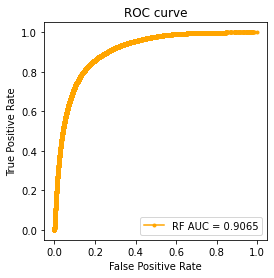

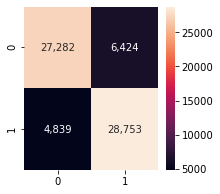

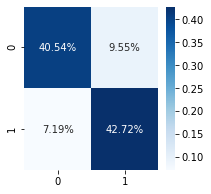

In [115]:
# AUC
probs = np.array(pred_prob(test_iter, net))[:, 1]

rf_auc = roc_auc_score(test_label, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model81
rf_fpr, rf_tpr, _ = roc_curve(test_label, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()